# Flight Delay Forecast
  
**Author**: Chuhan Bin (cbin), Dongyang Lu (dongyanl), Jingwen Hou (jingwenh)  

In [1]:
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import learning_curve, train_test_split
from pylab import rcParams
from scipy.stats import norm
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split
import itertools
from sklearn import metrics
from pylab import rcParams

In [2]:
# Loading data
jan_df = pd.read_csv("1.csv")
for i in range(2, 13):
    read_df = pd.read_csv(str(i) + ".csv")
    jan_df = pd.concat([jan_df, read_df])

## Introduction

In this notebook, our team develops a model aimed at predicting flight delays. The goals of the project are: 
- predict whether a flight would delay
- predict the probability of delay
- investigate the dominant factors of flight delay. 

The dataset we used are 2017 On-Time Performance data from Bureau Of Transportation Statistics and 2017 weather data from Iowa Environmental Mesonet. We first import the flight data from csv file into pandas dataframe and use various graphing tools to visualize the dataset to get a sense of the relationship between features and results, then we processed data to get most relavant features and trained our model using random forests algorithm.
  
Following are the sections we will go through: 
1. Data exploration: in this section, we will explain the data we are going to use as well as have visualzation on the data.
2. Data preprocessing: in this section, we will process the data according to the usage of the data and the understanding from the visualization
3. Modeling: in this section, we uses Random Forest for the prediction, whose process includes parameter tuning, training, and evaluation.

## Data Exploration

Each entry of the ".csv" file corresponds to a flight and we see that more than 7M flights have been recorded in 2017. These flights are described by 29 variables. A description of these variables can be found here (https://www.transtats.bts.gov/ONTIME/). Below is a short description of the meaning of the variables that will be used in this notebook:

- YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK: dates of the flight 
- AIRLINE_ID: An identification number assigned by US DOT to identify a unique airline 
- ORIGIN and DEST: code attributed by IATA to identify the airports 
- DEP_TIME and ARR_TIME : scheduled times of take-off and landing 
- DEP_DELAY and ARR_DELAY: difference between planned and real times 
- DISTANCE: flight route distance (in miles) 

The weather data is obtained from Iowa Environmental Mesonet (https://mesonet.agron.iastate.edu/request/download.phtml?network=CA_ASOS). The features we select include:
- vsby: Visibility in miles
- p01i: One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.
- mslp: Sea Level Pressure in millibar
- alti: Pressure altimeter in inches
- sped: Wind speed in mph
- drct: Wind Direction in degrees from north
- relh: Relative Humidity in %
- dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
- tmpf: Air Temperature in Fahrenheit, typically @ 2 meters

Because there are multiple information in the dataset implying flight delay, including arrival delay and departure delay. We select arrival delay as our label and process it to 0 and 1 (0 means on-time and 1 means delay). Because in real life, no matter whether the flight will depart late, you still need to arrive at the airport in time. But arrival delay is more useful for planning the trip.

### Data Preparation

In the data preparation part, we load data from flight information dataset and weather information dataset and finished some basic preprocessing:
- Convert date data into datetime format, because the data given is string or integer type
- Convert continuous weather data into float
- Count the majority value of 'skyc1' and use the majority value as the sky level coverage of that day
- Merge the weather dataframe and the flight information dataframe on date and destination

In [3]:
jan_df.dtypes

YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                 object
UNIQUE_CARRIER          object
AIRLINE_ID               int64
CARRIER                 object
TAIL_NUM                object
FL_NUM                   int64
ORIGIN                  object
DEST                    object
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DELAY_NEW          float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
FLIGHTS                float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 29            float64
dtype: object

In [4]:
jan_df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29
0,2017,1,1,7,6,2017-01-07,AA,19805,AA,N3ESAA,...,432.0,366.0,1.0,2611.0,0.0,7.0,21.0,0.0,0.0,NaN
1,2017,1,1,8,7,2017-01-08,AA,19805,AA,N3NSAA,...,414.0,375.0,1.0,2611.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,9,1,2017-01-09,AA,19805,AA,N876AA,...,414.0,392.0,1.0,2611.0,27.0,0.0,2.0,0.0,0.0,NaN
3,2017,1,1,10,2,2017-01-10,AA,19805,AA,N3HMAA,...,429.0,390.0,1.0,2611.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,11,3,2017-01-11,AA,19805,AA,N3BMAA,...,444.0,405.0,1.0,2611.0,0.0,0.0,25.0,0.0,0.0,NaN


In [5]:
jan_df.head().loc[:, ["ARR_DELAY"]]

,ARR_DELAY
0,28.0
1,7.0
2,29.0
3,11.0
4,25.0


We convert flight date to from datetime to string and convert the continuous arrival delay time to categorical (0 and 1) as the prediction label.

In [6]:
jan_df["FL_DATE"] = jan_df["FL_DATE"].apply(lambda s : datetime.strptime(s, "%Y-%m-%d"))
# jan_df["DEP_DELAY_BOOLEAN"] = jan_df["DEP_DELAY"].apply(lambda x : 1 if x > 0 else 0)
jan_df["ARR_DELAY_BOOLEAN"] = jan_df["ARR_DELAY"].apply(lambda x : 1 if x > 0 else 0)

In [7]:
airports = [
    'MAF', 'LNK', 'JAN', 'GJT', 'ITO', 'TUS', 'DAB', 'ACT', 'BTV', 'JMS', 'RAP', 'AEX', 'FSD', 'SHV', 'CID', 'GPT', 'LRD', 'SNA', 
    'COS', 'SPI', 'CAK', 'STL', 'ROW', 'SYR', 'LFT', 'TXK', 'RSW', 'CLT', 'MYR', 'AGS', 'FAI', 'PGD', 'ATL', 'ACV', 'ATW', 'ORH', 
    'TLH', 'CWA', 'SJU', 'PVD', 'ADK', 'CDC', 'BTM', 'FWA', 'IAD', 'JAC', 'EAU', 'HDN', 'APN', 'DSM', 'MSN', 'SMF', 'GCC', 'HOU', 
    'DTW', 'ABY', 'IAG', 'CHA', 'COD', 'BPT', 'BLI', 'GTF', 'BMI', 'SAT', 'GRB', 'BQN', 'ABQ', 'PIT', 'BRD', 'SGF', 'LGB', 'ELP',
    'OTZ', 'SFO', 'MFE', 'IAH', 'LAN', 'HYS', 'JAX', 'PHX', 'CHO', 'BQK', 'CPR', 'GSO', 'GSP', 'DAY', 'ELM', 'ONT', 'IND', 'OME', 
    'EWN', 'RKS', 'DAL', 'TYR', 'MIA', 'PLN', 'ESC', 'SWF', 'LBB', 'PWM', 'MFR', 'SLC', 'CHS', 'RIC', 'SUN', 'HSV', 'SBN', 'BRW', 
    'GCK', 'TYS', 'OMA', 'MLU', 'VLD', 'SBP', 'PSP', 'SGU', 'PHL', 'CDV', 'LAS', 'RDM', 'TTN', 'LAX', 'SDF', 'ANC', 'BRO', 'YAK', 
    'INL', 'BWI', 'JFK', 'ORD', 'AMA', 'JNU', 'BIS', 'BFL', 'MOT', 'GEG', 'DFW', 'FAY', 'HLN', 'GTR', 'PPG', 'TUL', 'BTR', 'FNT', 
    'TVC', 'RDD', 'MMH', 'HNL', 'OKC', 'LEX', 'OAJ', 'CRW', 'LGA', 'MRY', 'ROC', 'FAT', 'EKO', 'CVG', 'ASE', 'KOA', 'ILM', 'TRI', 
    'MCO', 'LIT', 'OAK', 'SAV', 'GUC', 'MDT', 'GRI', 'BGM', 'GGG', 'ABE', 'PIA', 'OGG', 'DLH', 'TWF', 'MBS', 'TKI', 'PIH', 'DHN', 
    'EUG', 'SJT', 'MGM', 'LIH', 'LSE', 'BJI', 'GUM', 'RDU', 'FLL', 'SRQ', 'GNV', 'RNO', 'BHM', 'DVL', 'AVP', 'RST', 'HOB', 'EWR', 
    'CMX', 'CAE', 'FLG', 'PAH', 'CSG', 'SPS', 'STX', 'BUR', 'PSE', 'GRR', 'CIU', 'ISP', 'MDW', 'PDX', 'PHF', 'ICT', 'SCC', 'SIT', 
    'DRO', 'MLI', 'FSM', 'ECP', 'MOB', 'CMH', 'TPA', 'LBE', 'ORF', 'ABR', 'BET', 'LCH', 'ITH', 'MQT', 'SJC', 'ABI', 'MCI', 'MTJ',
    'SCE', 'SAN', 'DCA', 'MEM', 'MSO', 'CRP', 'SBA', 'IDA', 'YUM', 'BOI', 'MEI', 'STT', 'PSG', 'ERI', 'LAW', 'CLL', 'ISN', 'EYW', 
    'LAR', 'IMT', 'PBG', 'OTH', 'GRK', 'BZN', 'PIB', 'ACY', 'BUF', 'EGE', 'ALB', 'BNA', 'PBI', 'FAR', 'MHT', 'BDL', 'PNS', 'ADQ', 
    'XNA', 'BIL', 'CLE', 'ROA', 'HIB', 'KTN', 'SEA', 'MSY', 'BOS', 'MSP', 'AZO', 'AVL', 'WRG', 'VPS', 'PSC', 'MLB', 'GFK', 'AUS', 
    'EVV', 'RHI', 'HPN', 'LWS', 'SAF', 'MKG', 'FCA', 'HRL', 'DEN', 'MKE'
]

weather_df = pd.DataFrame()
for ap in airports:
    try:
        read_df = pd.read_csv("weather/"+ ap + "_201701010000_201712310000.txt",sep=',')
        read_df = read_df.rename(columns=lambda x: x.strip())
        read_df = read_df[(read_df['tmpf'] != 'M') & (read_df['dwpf'] != 'M') & (read_df['relh'] != 'M')
                         & (read_df['drct'] != 'M') & (read_df['sped'] != 'M') & (read_df['alti'] != 'M')
                         & (read_df['mslp'] != 'M') & (read_df['p01i'] != 'M') & (read_df['vsby'] != 'M')
                         & (read_df['skyc1'] != 'M')]
        weather_df = pd.concat([weather_df, read_df])
    except:
        continue
display(weather_df.head())

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station,valid,tmpf,dwpf,relh,drct,sped,alti,mslp,p01i,vsby,gust_mph,skyc1,presentwx
11,MAF,2016-12-31 23:53,48.00,41.00,76.58,140.00,8.1,29.90,1009.70,0.02,10.00,M,FEW,M
24,MAF,2017-01-01 00:53,48.90,39.00,68.51,170.00,5.8,29.88,1009.20,0.00,10.00,M,FEW,M
37,MAF,2017-01-01 01:53,48.90,39.00,68.51,200.00,5.8,29.87,1008.90,0.00,10.00,M,BKN,M
50,MAF,2017-01-01 02:53,48.00,39.90,73.38,200.00,8.1,29.87,1008.80,0.00,10.00,M,BKN,M
63,MAF,2017-01-01 03:53,45.00,39.00,79.36,240.00,3.5,29.88,1009.20,0.00,10.00,M,CLR,M


In [8]:
weather_df['date'] = weather_df['valid'].str[:10]
weather_df['date'] = weather_df['date'].apply(lambda s : datetime.strptime(s, "%Y-%m-%d"))
weather_df['tmpf'] = weather_df['tmpf'].astype('float')
weather_df['dwpf'] = weather_df['dwpf'].astype('float')
weather_df['relh'] = weather_df['relh'].astype('float')
weather_df['drct'] = weather_df['drct'].astype('float')
weather_df['sped'] = weather_df['sped'].astype('float')
weather_df['alti'] = weather_df['alti'].astype('float')
weather_df['mslp'] = weather_df['mslp'].astype('float')
weather_df['p01i'] = weather_df['p01i'].astype('float')
weather_df['vsby'] = weather_df['vsby'].astype('float')

In [9]:
weather_summary = pd.DataFrame()
weather_summary['tmpf'] = weather_df.groupby(['station','date'])['tmpf'].mean()
weather_summary['dwpf'] = weather_df.groupby(['station','date'])['dwpf'].mean()
weather_summary['relh'] = weather_df.groupby(['station','date'])['relh'].mean()
weather_summary['drct'] = weather_df.groupby(['station','date'])['drct'].mean()
weather_summary['sped'] = weather_df.groupby(['station','date'])['sped'].mean()
weather_summary['alti'] = weather_df.groupby(['station','date'])['alti'].mean()
weather_summary['mslp'] = weather_df.groupby(['station','date'])['mslp'].mean()
weather_summary['p01i'] = weather_df.groupby(['station','date'])['p01i'].mean()
weather_summary['vsby'] = weather_df.groupby(['station','date'])['vsby'].mean()
weather_summary = weather_summary.reset_index()
w = weather_df.groupby(['station','date'])['skyc1'].value_counts().groupby(['station','date']).idxmax()
weather_summary['skyc1'] = pd.Series([i[2] for i in w])

weather_summary.head()

,station,date,tmpf,dwpf,relh,drct,sped,alti,mslp,p01i,vsby,skyc1
0,ABE,2016-12-31,43.000000,23.000000,44.800000,250.000000,6.900000,29.880000,1012.100000,0.000000,10.000000,OVC
1,ABE,2017-01-01,38.952174,22.517391,53.052609,182.173913,5.613043,30.193913,1022.717391,0.000000,10.000000,CLR
2,ABE,2017-01-02,35.333333,30.512500,82.639583,73.333333,7.016667,30.372083,1028.862500,0.009167,5.291667,OVC
3,ABE,2017-01-03,39.354167,36.345833,88.875417,78.750000,7.504167,29.797083,1009.266667,0.019167,2.489583,OVC
4,ABE,2017-01-04,40.954167,27.116667,60.971250,262.500000,12.200000,29.579583,1001.850000,0.000000,8.166667,CLR


In [10]:
model_df = pd.DataFrame(jan_df)
X2 = model_df.drop("ARR_DELAY", axis = 1)
y2 = model_df.loc[:,"ARR_DELAY"]
model_df = pd.merge(model_df, weather_summary, left_on = ['DEST', 'FL_DATE'], 
                        right_on = ['station','date'], how = 'inner')
model_df = pd.concat([model_df, pd.get_dummies(model_df['skyc1'])], axis=1)

model_df = model_df.drop(['FL_DATE','ORIGIN', 'DEST', 
                          'CARRIER', 'DEP_TIME', 'DAY_OF_WEEK', 
                          'MONTH', 'station', 'date','skyc1'], axis = 1)
model_df.head()

,YEAR,QUARTER,DAY_OF_MONTH,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,DEP_DELAY,DEP_DELAY_NEW,ARR_TIME,...,alti,mslp,p01i,vsby,BKN,CLR,FEW,OVC,SCT,VV
0,2017,1,7,AA,19805,N3ESAA,305,7.0,7.0,2309.0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
1,2017,1,7,AA,19805,N3GFAA,333,99.0,99.0,NaN,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
2,2017,1,7,AA,19805,N3BRAA,370,7.0,7.0,1422.0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
3,2017,1,7,AA,19805,N789AA,381,90.0,90.0,1745.0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
4,2017,1,7,AA,19805,N808AA,443,61.0,61.0,1948.0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0


## Visualization

In this part, we have done visualization on our dataset. Here is a summary of our findings in visualization:
- The busiest route is LAX – SFO / SFO- LAX
- The company with most delays is Virgin America, ranked 1st with 48% delay rate, while the 2nd is 40%
- Delta Airline has the lowest delay rate 26%
- Flight at 2 am is most likely to delay, even though there are only few flights at that time
- Flight is most likely to delay on Friday
- June and January are two months with most delays
- It is very likely to have arrival delay if the departure delay is larger than 25 minutes


### Routes vs. Arrival Delay

We firstly want to see which routes are busy and which routes are not. Because the dataset has already provided the departure airport and arrival airport, so we use such data to draw a heatmap to show the number of delays happened to each route. Because showing all routes will make the heatmap too large, so we only show the top 18 of them. The y-axis shows the departure airport and the x-axis shows the arrival airport. From the heatmap, we can see certain airports have more counts of delays, such as LAX and SFO. 

In [11]:
# Get delay rows
res = []
for _, group in jan_df.groupby("ARR_DELAY_BOOLEAN"):
    res.append(group)
arr_ontime_df = res[0]
arr_delay_df = res[1]

airports = set()
for ap in jan_df["ORIGIN"]:
    airports.add(ap)
for ap in jan_df["DEST"]:
    airports.add(ap)

In [12]:
# Create matrix for routes
airports_df = pd.DataFrame(columns = airports)
airports_df["From/To"] = pd.Series(list(airports))
airports_df.set_index("From/To", inplace=True)
airports_df = airports_df.fillna(value=0)

In [13]:
# Count delays by route
airports_df_delay = pd.DataFrame(airports_df)

for _, row in arr_delay_df.iterrows():
    _from = str(row["ORIGIN"])
    _to =  str(row["DEST"])
    airports_df_delay.loc[_from, _to] = airports_df_delay.loc[_from, _to] + 1

In [14]:
# Count delays by airports
delay_counts = []
for name in airports_df_delay.index:
    delay_counts.append((len(airports) - list(airports_df_delay.loc[name, :]).count(0), name))

In [15]:
# Eliminate routes with less delays
least_delay_airports = [t[1] for t in sorted(delay_counts, reverse = True)[-280:]]
airports_df_delay_drops = pd.DataFrame(airports_df_delay)
airports_df_delay_drops = airports_df_delay_drops.drop(least_delay_airports)
airports_df_delay_drops = airports_df_delay_drops.drop(least_delay_airports, axis = 1)

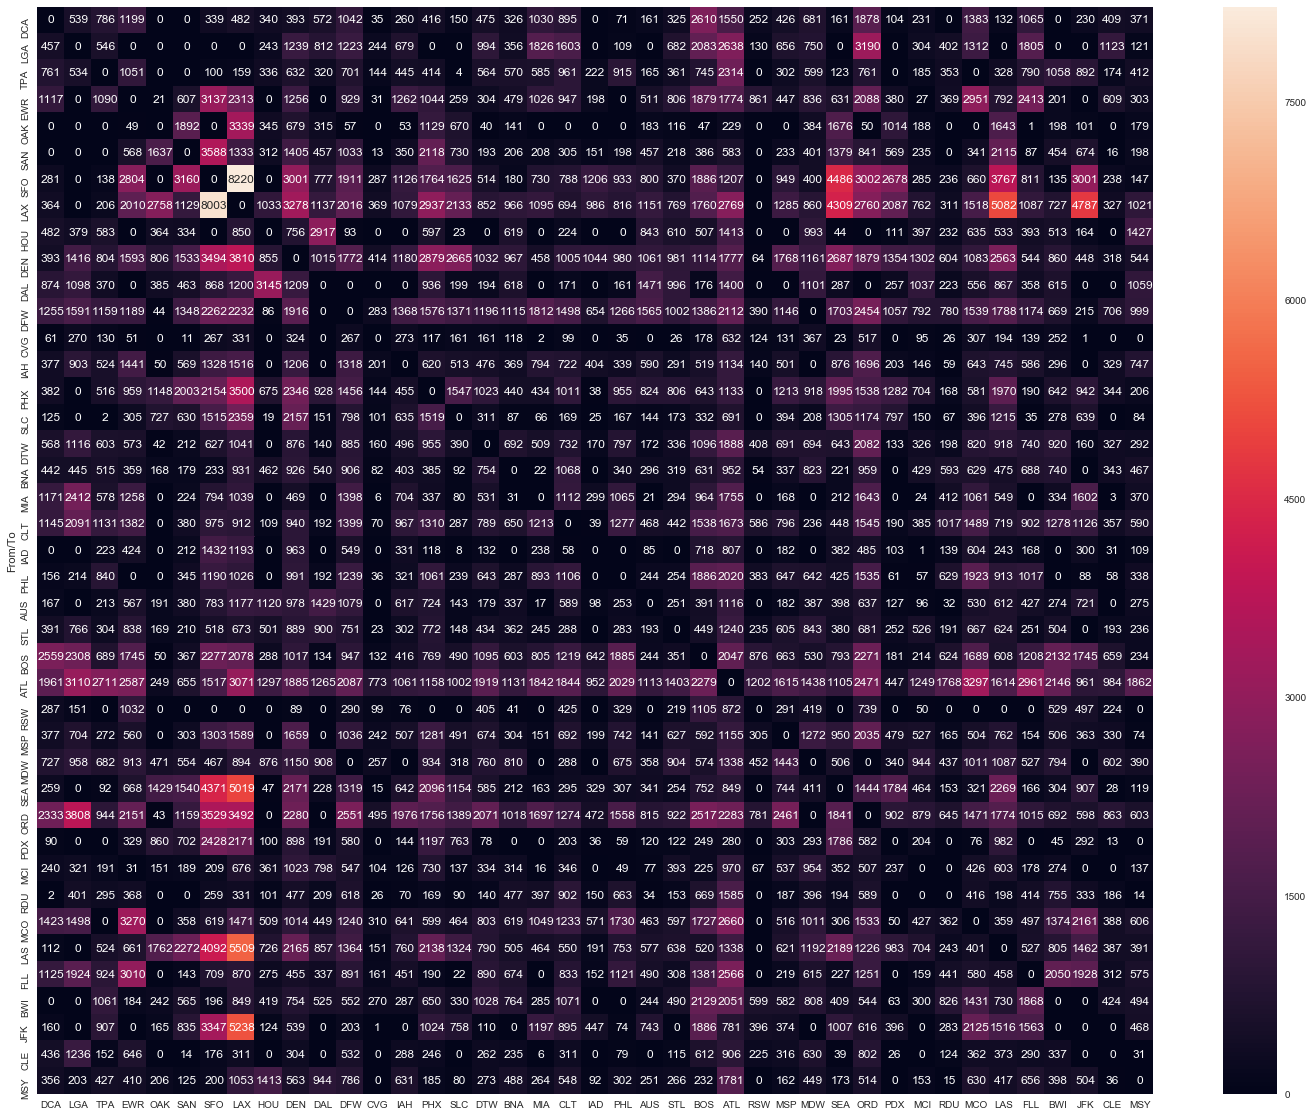

In [16]:
sns.set(rc={'figure.figsize':(25,20)})
delay_hm = sns.heatmap(airports_df_delay_drops, annot=True, fmt="d")
# delay_hm = sns.set(rc={'figure.figsize':(22,22)})
plt.show()

We also save the delay counts of routes and export it to pickle, which will be used in the feature engineering.

In [17]:
# Export delay counts of routes
routes = []
for _from in airports:
    for _to in airports:
        routes.append((airports_df_delay.loc[_from, _to], (_from, _to)))
routes.sort(reverse = True)
routes_dic = {}
for r in routes:
    if r[0] != 0:
        routes_dic[r[1][0] + '-' + r[1][1]] = r[0]
# print(routes_dic)

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('busy_routes.p', 'wb') as fp:
    pickle.dump(routes_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Carrier vs. Arrival Delay

In this part, we explore the delay rate for the most popular airline companies. To our surprise, Virgin America has the highest delay rate, which is 48%. Delta has the lowest delay rate of 26%.

In [18]:
carrier_groups = []
ontime_counts = pd.DataFrame(arr_ontime_df["CARRIER"]).groupby("CARRIER").size().to_frame('ontime_counts').reset_index()
delay_counts = pd.DataFrame(arr_delay_df["CARRIER"]).groupby("CARRIER").size().to_frame('delay_counts').reset_index()
ontime_delay_counts = pd.merge(ontime_counts, delay_counts, on='CARRIER')
ontime_delay_counts["DELAY_RATE"] = ontime_delay_counts.apply(lambda row : row[2] / (row[1] + row[2]), axis = 1)
ontime_delay_counts.sort_values(["DELAY_RATE"], ascending=False)

,CARRIER,ontime_counts,delay_counts,DELAY_RATE
10,VX,36595,33737,0.479682
11,WN,793612,537793,0.403929
2,B6,181198,118362,0.395120
6,HA,49672,30226,0.378307
1,AS,116695,68558,0.370078
5,F9,65207,36351,0.357933
0,AA,575278,319014,0.356722
8,OO,461234,236763,0.339203
7,NK,103498,52784,0.337748
4,EV,233683,113025,0.325995


## Time of The Day vs. Arrival Delay

We created line plots to visualize the relationship between flight time and delay rate. Insterestingly, flights depart at 2am has the highest delay rate, eventhough there are not many flights operated during that time. On the contrast, flights depart at 5am has the lowest delay rate. We used the same techniques to explore the relationship between 'day of week' and delay rate, as well as month and delay rate.

,DEP_TIME,ontime_counts,delay_counts,DELAY_RATE
2,02:00,1063,2257,0.679819
1,01:00,3920,6645,0.628964
3,03:00,668,989,0.596862
23,23:00,27501,35658,0.564575
0,00:00,12870,16105,0.555824
21,21:00,101639,89624,0.468590
22,22:00,82664,71596,0.464126
20,20:00,148857,123706,0.453862
18,18:00,172777,137661,0.443441
19,19:00,175378,130238,0.426149


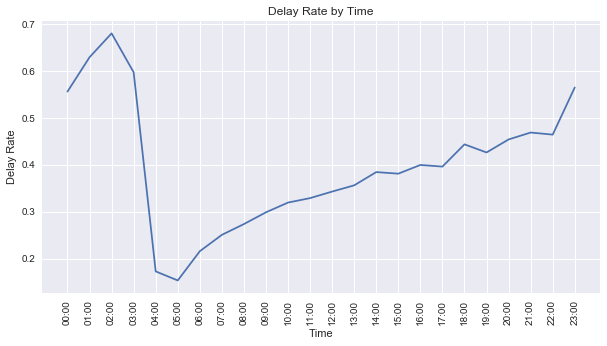

In [19]:
def process(t):
    t = int(t) - int(t) % 100
    if t == 2400:
        t = 0
    ts = str(t)
    if len(ts) == 4:
        return datetime.strptime(ts, "%H%M").strftime('%H:%M')
    while len(ts) < 4:
        ts = "0" + ts
    return datetime.strptime(ts, "%H%M").strftime('%H:%M')

dep_ontime = pd.DataFrame(arr_ontime_df["DEP_TIME"]).dropna(axis = 0, how = "any")
dep_ontime["DEP_TIME"] = dep_ontime["DEP_TIME"].apply(lambda x : process(x))

dep_delay = pd.DataFrame(arr_delay_df["DEP_TIME"]).dropna(axis = 0, how = "any")
dep_delay["DEP_TIME"] = dep_delay["DEP_TIME"].apply(lambda x : process(x))

ontime_counts = dep_ontime.groupby("DEP_TIME").size().to_frame('ontime_counts').reset_index()
delay_counts = dep_delay.groupby("DEP_TIME").size().to_frame('delay_counts').reset_index()
ontime_delay_counts = pd.merge(ontime_counts, delay_counts, on='DEP_TIME')
ontime_delay_counts["DELAY_RATE"] = ontime_delay_counts.apply(lambda row : row[2] / (row[1] + row[2]), axis = 1)
display(ontime_delay_counts.sort_values(["DELAY_RATE"], ascending=False))

rcParams['figure.figsize'] = 10, 5
plt.xticks(rotation='vertical')
x = ontime_delay_counts["DEP_TIME"]
y = ontime_delay_counts["DELAY_RATE"]
plt.title('Delay Rate by Time')
plt.xlabel('Time')
plt.ylabel('Delay Rate')
plt.plot(x, y)
plt.show()

## Day of The Week vs. Arrival Delay

We also want to find whether some days of the week will have a significant higher delay rate. According to the analysis, we can see that Monday has the highest delay rate.

,DAY_OF_WEEK,ontime_counts,delay_counts,DELAY_RATE
4,5,522849,323679,0.382361
3,4,524681,316858,0.376522
0,1,527223,296964,0.360311
2,3,551032,280276,0.337151
6,7,542350,265408,0.328574
1,2,544399,261671,0.324626
5,6,486410,219353,0.310803


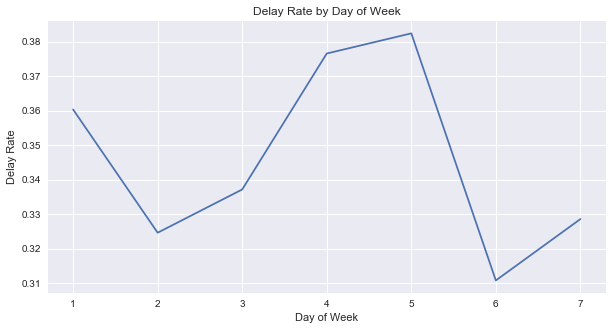

In [20]:
ontime_counts = pd.DataFrame(arr_ontime_df["DAY_OF_WEEK"]).groupby("DAY_OF_WEEK").size().to_frame('ontime_counts').reset_index()
delay_counts = pd.DataFrame(arr_delay_df["DAY_OF_WEEK"]).groupby("DAY_OF_WEEK").size().to_frame('delay_counts').reset_index()
ontime_delay_counts = pd.merge(ontime_counts, delay_counts, on='DAY_OF_WEEK')
ontime_delay_counts["DELAY_RATE"] = ontime_delay_counts.apply(lambda row : row[2] / (row[1] + row[2]), axis = 1)
display(ontime_delay_counts.sort_values(["DELAY_RATE"], ascending=False))

rcParams['figure.figsize'] = 10, 5
# plt.xticks(rotation='vertical')
x = ontime_delay_counts["DAY_OF_WEEK"]
y = ontime_delay_counts["DELAY_RATE"]
plt.title('Delay Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Delay Rate')
plt.plot(x, y)
plt.show()

## Month vs. Arrival Delay

So we also want to find the relationship between month and arrival delay. As the plot shows, January and June has the highest delay rate.

,MONTH,ontime_counts,delay_counts,DELAY_RATE
5,6,297951,196315,0.397185
0,1,277964,172053,0.382326
6,7,316177,192893,0.378913
7,8,319505,190946,0.374073
4,5,309214,177269,0.364389
3,4,602512,334146,0.356743
2,3,315928,172669,0.353398
10,12,304734,159471,0.343536
1,2,283568,126949,0.309242
8,9,332812,125915,0.274488


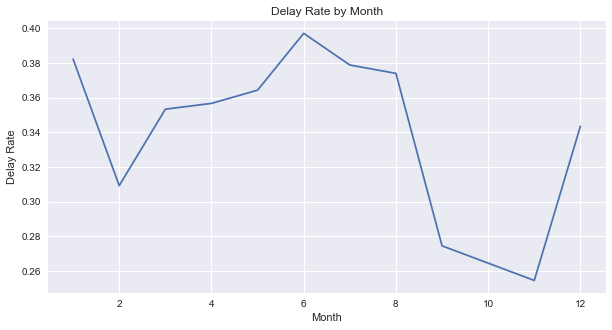

In [21]:
ontime_counts = pd.DataFrame(arr_ontime_df["MONTH"]).groupby("MONTH").size().to_frame('ontime_counts').reset_index()
delay_counts = pd.DataFrame(arr_delay_df["MONTH"]).groupby("MONTH").size().to_frame('delay_counts').reset_index()
ontime_delay_counts = pd.merge(ontime_counts, delay_counts, on='MONTH')
ontime_delay_counts["DELAY_RATE"] = ontime_delay_counts.apply(lambda row : row[2] / (row[1] + row[2]), axis = 1)
display(ontime_delay_counts.sort_values(["DELAY_RATE"], ascending=False))

rcParams['figure.figsize'] = 10, 5
# plt.xticks(rotation='vertical')
x = ontime_delay_counts["MONTH"]
y = ontime_delay_counts["DELAY_RATE"]
plt.title('Delay Rate by Month')
plt.xlabel('Month')
plt.ylabel('Delay Rate')
plt.plot(x, y)
plt.show()

## Air Time, Distances vs. Arrival Delay

All aboving analysis are focused on categorical features. We also wants to see the relationship between arrival delay and other continuous features. Firstly we will show the relationship between air time and distances using a histogram, with different color distinguishing on-time and delay. The only thing we can see is that the data is distributed in a normal distribution pattern with a left skewness.

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


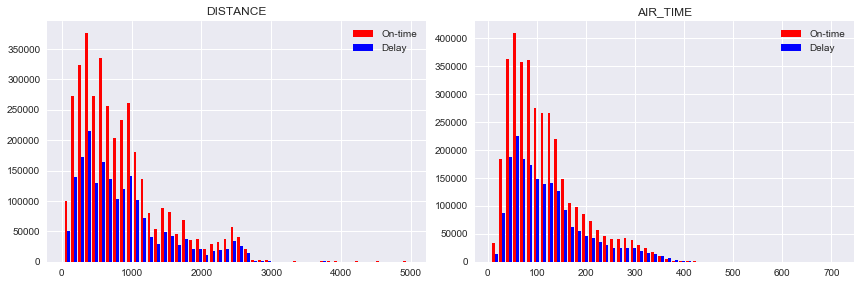

In [22]:
delay = pd.DataFrame(jan_df[jan_df['ARR_DELAY_BOOLEAN'] == 1])
onTime = pd.DataFrame(jan_df[jan_df['ARR_DELAY_BOOLEAN'] == 0])
observe = ["DISTANCE","AIR_TIME"]

plt.rcParams.update({'font.size': 8})
plot, graphs = plt.subplots(nrows=1, ncols=2, figsize=(12,4)) # 生成50个空白图像
graphs = graphs.flatten()
for idx, graph in enumerate(graphs):
    graph.figure
    
    binwidth= (max(jan_df[observe[idx]]) - min(jan_df[observe[idx]]))/30 # 算出连续数据的范围，分成50个区间
    graph.hist([onTime[observe[idx]],delay[observe[idx]]], bins=50, label=['On-time','Delay'], color=['red','blue'])
    graph.legend(loc='upper right')
    graph.set_title(observe[idx])
plt.tight_layout()

## Depart Delay vs. Arrival Delay

As to depart delay vs. arrival delay, the pattern is a normal distribution with less skewness. Also, we can see a clear separation (approximately at the position of 15 minutes) between on-time and delay.

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


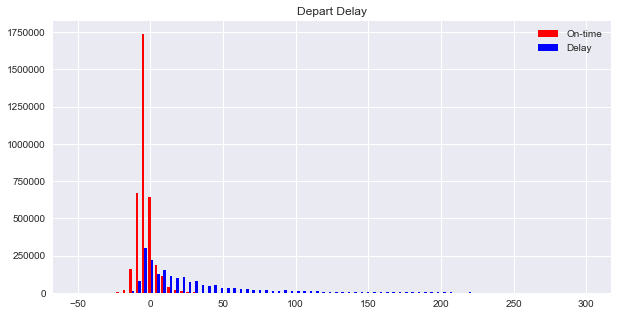

In [23]:
rcParams['figure.figsize'] = 10, 5
plt.hist([onTime["DEP_DELAY"],delay["DEP_DELAY"]], bins=80, label=['On-time','Delay'], color=['red','blue'], range=(-50, 300))
plt.title("Depart Delay")
plt.legend(loc='upper right')
plt.show()

## Weather vs. Arrival Delay

Apart from vsby and p01i, others weather data all distributed in a normal distribution pattern, but we also cannot see any separation between on-time and delay.

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


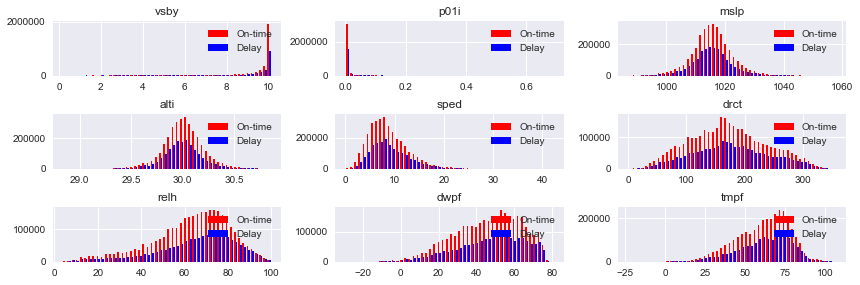

In [24]:
# rcParams['figure.figsize'] = 15, 10
delay = pd.DataFrame(model_df[model_df['ARR_DELAY_BOOLEAN'] == 1])
onTime = pd.DataFrame(model_df[model_df['ARR_DELAY_BOOLEAN'] == 0])
observe = ["vsby", "p01i", "mslp", "alti", "sped", "drct", "relh", "dwpf", "tmpf"]

plt.rcParams.update({'font.size': 8})
plot, graphs = plt.subplots(nrows= 3, ncols=3, figsize=(12,4))
graphs = graphs.flatten()
for idx, graph in enumerate(graphs):
    graph.figure
    
    binwidth= (max(model_df[observe[idx]]) - min(model_df[observe[idx]]))/30
    graph.hist([onTime[observe[idx]],delay[observe[idx]]], bins=50, label=['On-time','Delay'], color=['red','blue'])
    graph.legend(loc='upper right')
    graph.set_title(observe[idx])
plt.tight_layout()

## Feature Engineering

Feature engineering is crucial in arrival delay modeling. We select features to model arrival delay from two aspects: flight information and airport weather conditions. 
- Flight information: Intuitively, whether a flight will delay has much to do with basic flight information, such as distance and air time.
- Airport weather conditions: Given the rich literatures on the connection between flight delay and the weather conditions of airports, we think of the airport weather conditions as another type of factor possibly related to arrival delay.

Details about all features are described in the Data Exploration section.

### Data Preparation

Here we load the data again to make sure the data is the original data. After data pre-processing, the data set contains 4,983,863 flights in 2017 and 253 airports. There are 3,199,582 on-time flights and 1,784,282 arrival-delayed flights. The ratio of the two classes is 1.9: 1.

In [25]:
# Reload data
jan_df = pd.read_csv("1.csv")
for i in range(2, 13):
    read_df = pd.read_csv(str(i) + ".csv")
    jan_df = pd.concat([jan_df, read_df])

In [26]:
weather_df = pd.DataFrame()
for ap in airports:
    try:
        read_df = pd.read_csv("weather/"+ ap + "_201701010000_201712310000.txt",sep=',')
        read_df = read_df.rename(columns=lambda x: x.strip())
        read_df = read_df[(read_df['tmpf'] != 'M') & (read_df['dwpf'] != 'M') & (read_df['relh'] != 'M')
                         & (read_df['drct'] != 'M') & (read_df['sped'] != 'M') & (read_df['alti'] != 'M')
                         & (read_df['mslp'] != 'M') & (read_df['p01i'] != 'M') & (read_df['vsby'] != 'M')
                         & (read_df['skyc1'] != 'M')]
        weather_df = pd.concat([weather_df, read_df])
    except:
        continue
display(weather_df.head())

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


,station,valid,tmpf,dwpf,relh,drct,sped,alti,mslp,p01i,vsby,gust_mph,skyc1,presentwx
16,GPT,2016-12-31 23:53,66.00,64.90,96.24,210.00,6.9,29.94,1013.90,0.71,4.00,M,FEW,VCTS RA BR
33,GPT,2017-01-01 00:53,66.00,64.90,96.24,0.00,0.0,29.92,1013.10,0.71,0.50,M,BKN,+RA FG
54,GPT,2017-01-01 01:53,66.00,66.00,100.00,180.00,6.9,29.94,1013.80,0.51,3.00,M,BKN,RA BR
70,GPT,2017-01-01 02:53,66.90,66.00,96.93,0.00,0.0,29.93,1013.50,0.39,10.00,M,FEW,M
85,GPT,2017-01-01 03:53,66.00,66.00,100.00,150.00,8.1,29.93,1013.50,0.15,5.00,M,BKN,VCTS -RA BR


In [27]:
df = pd.DataFrame()
df["FL_DATE"] = jan_df["FL_DATE"]
df["FL_DATE"] = jan_df["FL_DATE"].apply(lambda s : datetime.strptime(s, "%Y-%m-%d"))
df["ORIGIN"] = jan_df["ORIGIN"]
df["DEST"] = jan_df["DEST"]
df["CARRIER"] = jan_df["CARRIER"]
df["DEP_TIME"] = jan_df["DEP_TIME"]
df["DAY_OF_WEEK"] = jan_df["DAY_OF_WEEK"]
df["MONTH"] = jan_df["MONTH"]
df["DEP_DELAY"] = jan_df["DEP_DELAY"]
df["DISTANCE"] = jan_df["DISTANCE"]
df["AIR_TIME"] = jan_df["AIR_TIME"]
df["ARR_DELAY"] = jan_df["ARR_DELAY"]

df = df.dropna(how='any', axis = 0)
df.head()

,FL_DATE,ORIGIN,DEST,CARRIER,DEP_TIME,DAY_OF_WEEK,MONTH,DEP_DELAY,DISTANCE,AIR_TIME,ARR_DELAY
0,2017-01-07,BOS,LAX,AA,1857.0,6,1,7.0,2611.0,366.0,28.0
1,2017-01-08,BOS,LAX,AA,1854.0,7,1,4.0,2611.0,375.0,7.0
2,2017-01-09,BOS,LAX,AA,1917.0,1,1,27.0,2611.0,392.0,29.0
3,2017-01-10,BOS,LAX,AA,1857.0,2,1,-6.0,2611.0,390.0,11.0
4,2017-01-11,BOS,LAX,AA,1856.0,3,1,-7.0,2611.0,405.0,25.0


### Preprocess Continuous Features of Flight Dataset

Firstly we process the continuous feature of Flight Dataset. According to the visualization, all the continuous data all have some skewnees. So we apply log transformation to those data to reduce the skewness.

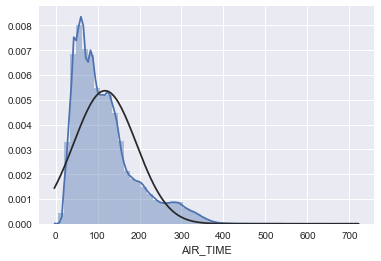

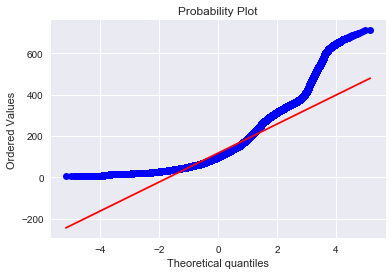

In [28]:
# Before transformation
rcParams['figure.figsize'] = 6, 4

sns.distplot(df["AIR_TIME"], fit=norm)
plt.show()
stats.probplot(df['AIR_TIME'], plot=plt)
plt.show()

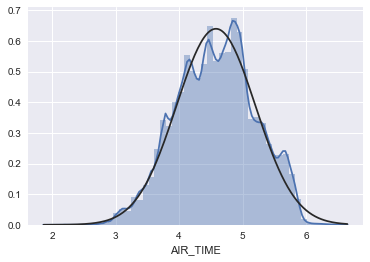

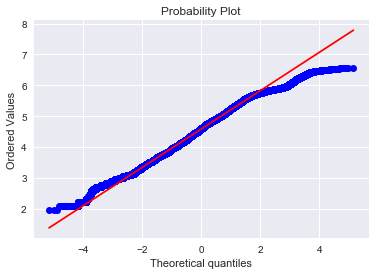

In [29]:
# After transformation
df["AIR_TIME"] = np.log(df["AIR_TIME"])
sns.distplot(df["AIR_TIME"], fit=norm)
plt.show()
stats.probplot(df['AIR_TIME'], plot=plt)
plt.show()

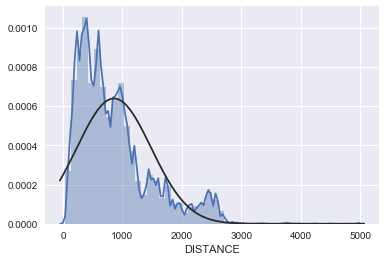

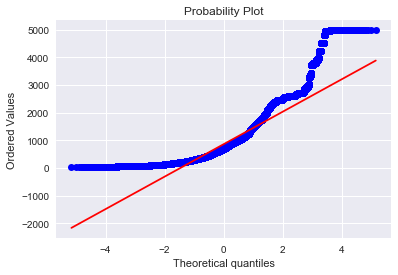

In [30]:
# Before transformation
rcParams['figure.figsize'] = 6, 4

sns.distplot(df["DISTANCE"], fit=norm)
plt.show()
stats.probplot(df['DISTANCE'], plot=plt)
plt.show()

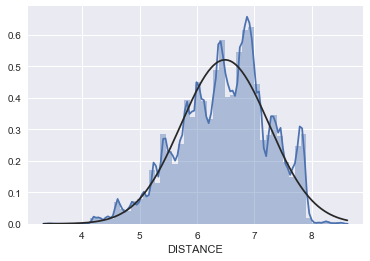

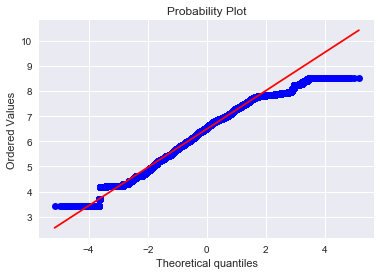

In [31]:
# After transformation
df["DISTANCE"] = np.log(df["DISTANCE"])
sns.distplot(df["DISTANCE"], fit=norm)
plt.show()
stats.probplot(df['DISTANCE'], plot=plt)
plt.show()

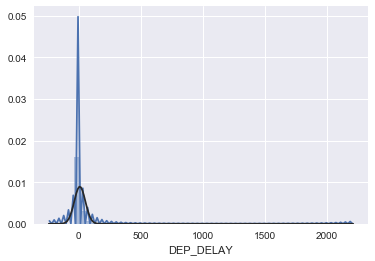

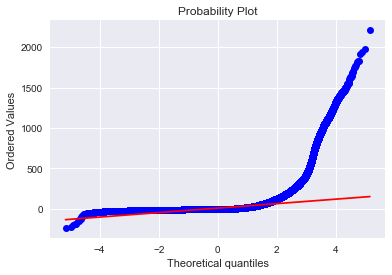

In [32]:
# Before transformation
rcParams['figure.figsize'] = 6, 4

sns.distplot(df["DEP_DELAY"], fit=norm)
plt.show()
stats.probplot(df['DEP_DELAY'], plot=plt)
plt.show()

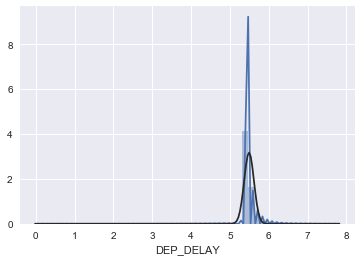

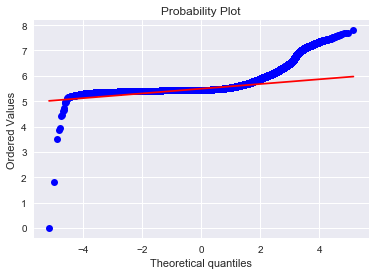

In [33]:
# After transformation
# Because some of the values are negative, we need to shift all values to positive before log transformation
df["DEP_DELAY"] = np.log(df["DEP_DELAY"]- min(df["DEP_DELAY"]) + 1)
# df["DEP_DELAY"].describe()
sns.distplot(df["DEP_DELAY"], fit=norm)
plt.show()
stats.probplot(df['DEP_DELAY'], plot=plt)
plt.show()

### Preprocess Categorical Features of Flight Data

Here we preprocess all categorical features of flight data. The mainly technique for preprocessing categorical feature is one-hot encoding. However, some of the features, such as route(combination of departure airport and arrival airport), has far too many categories, so we want to shrink it into smaller size of categories:
- Route: we split the route into very busy, busy, slightly busy and not busy accoding to the counts of delays
- Time of the day: round the specific time to hour (for example, 12:34 -> 12:00)
- Day of the week, Month: convert to integer (Monday -> 1, Jan -> 1)


In [34]:
# Convert arrival delay time to categorical (delay, on-time)
def splitIntervals(delay_minutes):
    if delay_minutes <= 0:
        return 0 # "On-time or early"
    else:
        return 1
df["ARR_DELAY"] = df["ARR_DELAY"].apply(lambda x : splitIntervals(x))
# df.head()

In [35]:
df["ROUTE"] = df.apply(lambda x : x[1] + "-" + x[2], axis = 1)

In [36]:
with open('busy_routes.p', 'rb') as fp:
    busy_routes = pickle.load(fp)
counts = list(busy_routes.values())
mid = (max(counts) + min(counts)) / 2
i1 = (min(counts) + mid) / 2
i2 = (max(counts) + mid) / 2
# print(min(counts), i1, mid, i2, max(counts))
def processRoute(x):
    if x in busy_routes:
        delay_counts = busy_routes[x]
        if delay_counts >= i2:
            return "Very busy" # "Very busy"
        elif delay_counts < i2 and delay_counts >= mid:
            return "Busy" # "Busy"
        elif delay_counts < mid and delay_counts >= i1:
            return "Slightly busy" # "Slightly busy"
    return "Not busy" # "Not busy"
df["ROUTE"] = df["ROUTE"].apply(lambda x : processRoute(x))
# df.loc[:, "ROUTE"]

In [37]:
def processTime(t):
    t = int(t) - int(t) % 100
    if t == 2400:
        t = 0
    ts = str(t)
    if len(ts) == 4:
        return datetime.strptime(ts, "%H%M").strftime('%H:%M')
    while len(ts) < 4:
        ts = "0" + ts
    return datetime.strptime(ts, "%H%M").strftime('%H:%M')

df["DEP_TIME"] = df["DEP_TIME"].apply(lambda x : processTime(x))
# df.head()

In [38]:
def processWeekDay(d):
    dic = {
        1:"Mon",
        2:"Tue",
        3:"Wed",
        4:"Thu",
        5:"Fri",
        6:"Sat",
        7:"Sun"
    }
    return dic[int(d)]
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].apply(lambda x : processWeekDay(x))
# df.head()

In [39]:
def processMonth(d):
    dic = {
        1:"Jan",
        2:"Feb",
        3:"Mar",
        4:"Apr",
        5:"May",
        6:"Jun",
        7:"Jul",
        8:"Aug",
        9:"Sep",
        10:"Oct",
        11:"Nov",
        12:"Dec"
    }
    return dic[int(d)]
df["MONTH"] = df["MONTH"].apply(lambda x : processMonth(x))
# df.head()

In [40]:
df = pd.concat([df, pd.get_dummies(df["ROUTE"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["CARRIER"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["DEP_TIME"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["DAY_OF_WEEK"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["MONTH"])], axis=1)
print(list(df.columns))

['FL_DATE', 'ORIGIN', 'DEST', 'CARRIER', 'DEP_TIME', 'DAY_OF_WEEK', 'MONTH', 'DEP_DELAY', 'DISTANCE', 'AIR_TIME', 'ARR_DELAY', 'ROUTE', 'Busy', 'Not busy', 'Slightly busy', 'Very busy', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', 'OO', 'UA', 'VX', 'WN', '00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Sep']


### Preprocess Features of Weather Data

Here we preprocess all numerical and categorical features of weather data with following methods:
- For each numerical feature, we calculate the average number of the feature per day by station and use the average number as the feature of that station and that day. 
- For the categorical feature, 'skyc1', we count its majority value per day by station and use the majority value as the sky level coverage of that station and that day.

In [41]:
weather_df['date'] = weather_df['valid'].str[:10]
weather_df['date'] = weather_df['date'].apply(lambda s : datetime.strptime(s, "%Y-%m-%d"))
weather_df['tmpf'] = weather_df['tmpf'].astype('float')
weather_df['dwpf'] = weather_df['dwpf'].astype('float')
weather_df['relh'] = weather_df['relh'].astype('float')
weather_df['drct'] = weather_df['drct'].astype('float')
weather_df['sped'] = weather_df['sped'].astype('float')
weather_df['alti'] = weather_df['alti'].astype('float')
weather_df['mslp'] = weather_df['mslp'].astype('float')
weather_df['p01i'] = weather_df['p01i'].astype('float')
weather_df['vsby'] = weather_df['vsby'].astype('float')

In [42]:
weather_summary = pd.DataFrame()
weather_summary['tmpf'] = weather_df.groupby(['station','date'])['tmpf'].mean()
weather_summary['dwpf'] = weather_df.groupby(['station','date'])['dwpf'].mean()
weather_summary['relh'] = weather_df.groupby(['station','date'])['relh'].mean()
weather_summary['drct'] = weather_df.groupby(['station','date'])['drct'].mean()
weather_summary['sped'] = weather_df.groupby(['station','date'])['sped'].mean()
weather_summary['alti'] = weather_df.groupby(['station','date'])['alti'].mean()
weather_summary['mslp'] = weather_df.groupby(['station','date'])['mslp'].mean()
weather_summary['p01i'] = weather_df.groupby(['station','date'])['p01i'].mean()
weather_summary['vsby'] = weather_df.groupby(['station','date'])['vsby'].mean()
weather_summary = weather_summary.reset_index()
w = weather_df.groupby(['station','date'])['skyc1'].value_counts().groupby(['station','date']).idxmax()
weather_summary['skyc1'] = pd.Series([i[2] for i in w])

weather_summary.head()

,station,date,tmpf,dwpf,relh,drct,sped,alti,mslp,p01i,vsby,skyc1
0,ABE,2016-12-31,43.000000,23.000000,44.800000,250.000000,6.900000,29.880000,1012.100000,0.000000,10.000000,OVC
1,ABE,2017-01-01,38.952174,22.517391,53.052609,182.173913,5.613043,30.193913,1022.717391,0.000000,10.000000,CLR
2,ABE,2017-01-02,35.333333,30.512500,82.639583,73.333333,7.016667,30.372083,1028.862500,0.009167,5.291667,OVC
3,ABE,2017-01-03,39.354167,36.345833,88.875417,78.750000,7.504167,29.797083,1009.266667,0.019167,2.489583,OVC
4,ABE,2017-01-04,40.954167,27.116667,60.971250,262.500000,12.200000,29.579583,1001.850000,0.000000,8.166667,CLR


### Merge Flight Data and Weather Data

After all data preprocessing for both datasets, we then merge the flight data and weather data on date and destination. For machine learning purposes, we randomly split the dataset into training set (80%) and test set (20%).

In [43]:
model_df = pd.DataFrame(df)
X2 = model_df.drop("ARR_DELAY", axis = 1)
y2 = model_df.loc[:,"ARR_DELAY"]
model_df = pd.merge(model_df, weather_summary, left_on = ['DEST', 'FL_DATE'], 
                        right_on = ['station','date'], how = 'inner')
model_df = pd.concat([model_df, pd.get_dummies(model_df['skyc1'])], axis=1)

model_df = model_df.drop(['FL_DATE','ORIGIN', 'DEST', 
                          'CARRIER', 'DEP_TIME', 'DAY_OF_WEEK', 
                          'MONTH', 'ROUTE', 'station', 'date','skyc1'], axis = 1)
model_df.head()

,DEP_DELAY,DISTANCE,AIR_TIME,ARR_DELAY,Busy,Not busy,Slightly busy,Very busy,AA,AS,...,alti,mslp,p01i,vsby,BKN,CLR,FEW,OVC,SCT,VV
0,5.488938,7.867489,5.902633,1,0,0,1,0,1,0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
1,5.488938,7.118826,5.204007,1,0,0,1,0,1,0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
2,5.783825,7.813996,5.877736,1,1,0,0,0,1,0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
3,5.690359,7.493874,5.568345,1,0,1,0,0,1,0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0
4,5.472271,7.503290,5.609472,1,0,1,0,0,1,0,...,30.16375,1021.3125,0.00125,10.0,0,0,0,0,1,0


In [44]:
X3 = model_df.drop("ARR_DELAY", axis = 1)
y3 = model_df.loc[:,"ARR_DELAY"]
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, y3, test_size=0.2)

## Modeling

### Parameter Tuning

We tune the parameters of our Random Forest model with grid search and cross validation. Firstly we plot the score vs. parameter value graphs for seven variables. From this plot, we are able to estimate a reasonable range for each parameter to try in GridSearchCV. This method will cut down on the time searching optimum parameters. However, the downside is that the optimum parameters may still fall outside of these ranges.

In [45]:
def evaluate_param(parameter, param_range, index):
    grid_search = GridSearchCV(rf, param_grid = {parameter: param_range})
    grid_search.fit(X3_train, Y3_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
        
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [46]:
param_grid = {'n_estimators': np.arange(2, 100, 2),
               'criterion': ['gini', 'entropy'],
               'max_depth': np.arange(1, 28, 1),
               'min_samples_split': np.arange(1,150,1),
               'min_samples_leaf': np.arange(1,60,1),
               'max_leaf_nodes': np.arange(2,60,1),
               'min_weight_fraction_leaf': np.arange(0.1,0.4, 0.1)}
rf= RandomForestClassifier()
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1
    print (index)  

In [47]:
param_grid2 = {'criterion': ['gini'],
               "n_estimators": [13,14,15,42,43,44],
              "max_depth": [3, 5],
              "min_samples_split": [15, 20],
              "min_samples_leaf": [2, 3, 4],
              "max_leaf_nodes": [10, 20],
              "min_weight_fraction_leaf": [0.1]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid=param_grid2)
clf.fit(X3_train, Y3_train)
clf.grid_scores_, clf.best_params_, clf.best_score_ 

In [48]:
parameters = {'criterion':['entropy','gini'],'max_depth':[5,15,16],'n_estimators':[13,44]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose = 2)
clf.fit(X3_train, Y3_train)

In [49]:
clf.grid_scores_, clf.best_params_, clf.best_score_

### Training

We train a random forest classifier to fit our data. The dependent variable is represented by a binary value, indicating on-time or delay.

In [50]:
clf = RandomForestClassifier(max_depth=16, criterion = 'gini',n_estimators=44)
clf.fit(X3_train, Y3_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=44, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Evaluation

We used two metrics, percent correct and AUC, to measure model accuracy. Both percent correct and AUC show high performance on both the training and test sets. So we have confidence that our model generalizes to unseen flights, and are able to interpret our parameter estimates as there is no evidence of overfitting.

#### Percent Correct
Percent Correct is simply the percent of correct model predictions. The average percent correct for a five-fold cross validation on training set is 83.5% and the percent correct for the test set is 83.6%.

In [51]:
cross_val_score(clf, X3_train, Y3_train, cv=5)

array([0.83585543, 0.83630939, 0.83632193, 0.83622747, 0.83728965])

In [52]:
clf.score(X3_test, Y3_test)

0.8363428784688188

#### Model Misclassifications
Typically, it is necessary to examine a classifier’s misclassifications for each class of the dependent variable. Below, we plot the confusion matrix for test data to help evaluate the model. The correct classifications are in the left top cell and the bottom right cell. The misclassifications are in the right top cell and the left bottom cell. 

The confusion matrix shows that more correct classifications on on-time flights than on delayed fights. Most misclassifications occurred as false negatives (bottom left cell), while false positives (top right cell) is a minor problem. That is, the classifier is more likely to overlook a arrival delay case than incorrectly assert flight delay when a flight is on time.

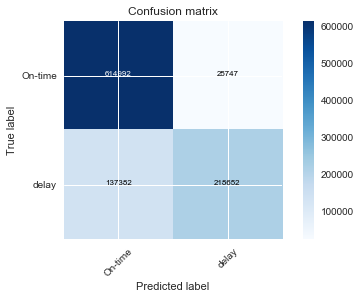

array([[614992,  25747],
       [137382, 218652]])

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

prediction = clf.predict(X3_test)
cnf_matrix = confusion_matrix(Y3_test, prediction)
plot_confusion_matrix(cnf_matrix, classes={"On-time": "On-time", "delay": "delay"},title='Confusion matrix')
plt.show()
cnf_matrix

#### ROC Curve and AUC
In addition to percent correct, we also plot the ROC curve and use AUC to measure model accuracy. AUC is area under curve of the ROC. AUC measures how well the model is able to classify an instance of a binary category. The possible range of this metric is from 0.5 to 1. 0.5 means a random classification, and 1 means a perfect classification. The AUC for the test set is 0.79.

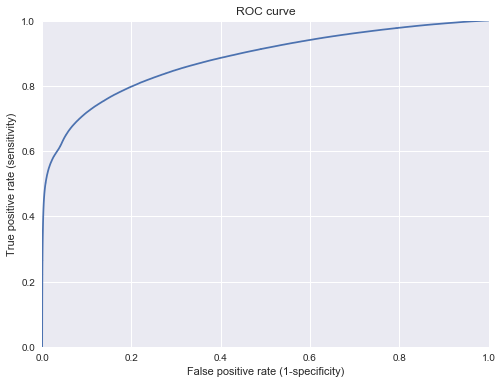

In [54]:
def plot_roc(clf, X_test, y_test):
    """
    Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    plt.figure(figsize=(8, 6))
#     m=np.arange(3)
#     for m in m:
    y_p =clf.predict_proba(X_test)[:,1]# Results of positive
#     y_p =clf.predict(X_test)
    fpr, tpr,thresholds= metrics.roc_curve(y_test,y_p) # Calculate false positve and true positive by adjusting thresholds
#     print("False positive: ")
#     print(fpr)
#     print("True positive: ")
#     print(tpr)
#     print("Threshold: ")
#     print(thresholds)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.title('ROC curve')
    plt.xlabel('False positive rate (1-specificity)')
    plt.ylabel('True positive rate (sensitivity)')
#     plt.legend(loc=4,)
plot_roc(clf, X3_test, Y3_test)
plt.show()

In [55]:
roc_auc_score(Y3_test, prediction)

0.7869745348931737

#### Feature Importance
Among the features reflecting flight information, "DEP_DELAY", "DISTANCE", and "AIR_TIME" are the most important features and are positively associated with arrival delay. All of these results are in the expected direction.

In the features for airport weather conditions, "p01i", one hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset, is the most important feature. In general, higher amount of precipitation for a certain period is positively associated with flight delay.

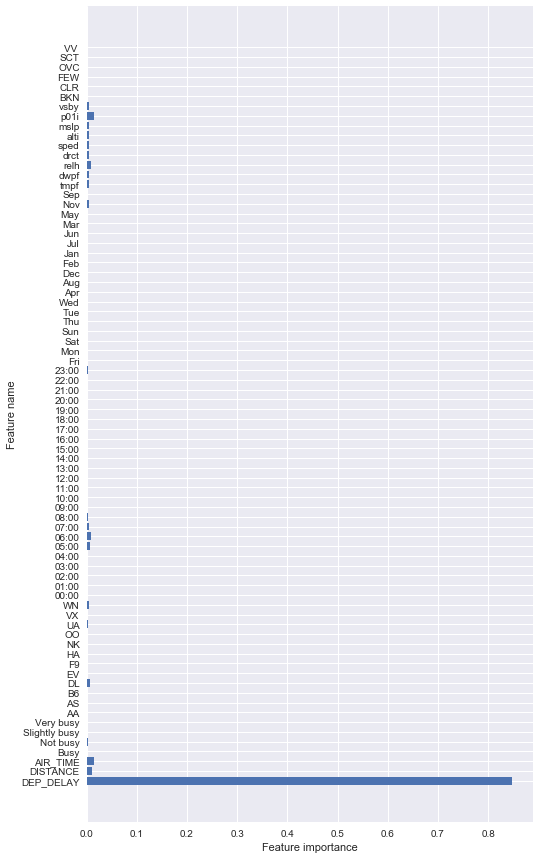

In [56]:
rcParams['figure.figsize'] = 8, 15

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

plot_feature_importances(clf, X3_train.columns.values)
plt.show()

### Predition of Delay Probability on Test Set

Finally, we make a prediction of delay probability on test set with probability estimates in the Random Forest model.

In [57]:
y_predict = clf.predict(X3_test)
y_predict_prob = clf.predict_proba(X3_test)
res = pd.DataFrame()
res["label"] = Y3_test
res["predict"] = y_predict
res["on-time probability"] = y_predict_prob[:, 0]
res["late probability"] = y_predict_prob[:, 1]
res[:5]

,label,predict,on-time probability,late probability
4854830,0,0,0.708633,0.291367
2622312,0,0,0.660521,0.339479
2371517,1,1,0.068754,0.931246
2622067,0,0,0.765951,0.234049
530533,0,0,0.848013,0.151987
